In [1]:
import numpy as np
import pandas as pd

from os.path import join

# Get covariates (Trait and State scores)

In [2]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))

yoked = pd.read_excel(join(eCON,'SCR_new/scripts/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

In [3]:
scores.head()

,SubID,Group,TRAIT,STATE
0,CON001,control,27,24
1,CON002,control,27,26
2,CON003,control,36,26
3,CON004,control,21,21
4,CON005,control,33,26


In [4]:
cov_df = pd.DataFrame()
for i, row in yoked.iterrows():
    TM = (scores[scores['SubID']==row['uncontrol']]['TRAIT'].values + scores[scores['SubID']==row['control']]['TRAIT'].values)/2
    SM = (scores[scores['SubID']==row['uncontrol']]['STATE'].values + scores[scores['SubID']==row['control']]['STATE'].values)/2

    TD = scores[scores['SubID']==row['uncontrol']]['TRAIT'].values - scores[scores['SubID']==row['control']]['TRAIT'].values
    SD = scores[scores['SubID']==row['uncontrol']]['STATE'].values - scores[scores['SubID']==row['control']]['STATE'].values
    
    tmp_df = pd.DataFrame([TM, TD, SM, SD],index=['TRAITmean','TRAITdiff','STATEmean','STATEdiff']).T
    tmp_df['Pair'] = 'P{:02d}'.format(i)
    cov_df = pd.concat([cov_df,tmp_df],axis=0,ignore_index=True)


In [5]:
yoked.head()

,control,uncontrol,run0,run1,run2,run3,run4,run5,use
0,CON001,CON031,1,1,1,1,1,0,1
1,CON002,CON021,1,1,1,1,1,1,1
2,CON003,CON022,1,1,1,1,1,1,1
3,CON004,CON030,1,1,1,1,1,1,1
4,CON005,CON023,1,1,1,1,1,1,1


In [6]:
cov_df.head()

,TRAITmean,TRAITdiff,STATEmean,STATEdiff,Pair
0,27.0,0.0,23.0,-2.0,P00
1,31.5,9.0,28.0,4.0,P01
2,36.5,1.0,27.5,3.0,P02
3,22.5,3.0,20.5,-1.0,P03
4,33.0,0.0,29.0,6.0,P04


## Get button presses

In [7]:
DATPAT = join(eCON,'onsetdir/{subj}/subj{subj}_run{run}.dat')

In [8]:
from json import load
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.DataFrame()
shock_durs = []

for i, row in yoked.iterrows():
    subj = row['uncontrol']
    runs = np.arange(6)[row.loc['run0':'run5'].astype(bool)]
    for j, run in enumerate(runs):
        path = DATPAT.format(subj=subj, run=run)
        with open(path, 'r') as f:
            data = load(f)
            
        numEsc = len(list(itertools.chain(*data['Escapes'])))
        numNonEsc = len(data['nonEscapes'])
        tmp_df_uncon = pd.DataFrame(['P{:02d}'.format(i),'uncontrol',subj,j,numNonEsc],index=['Pair','Group','Subject','run','buttPress']).T
        tmp_df_con = pd.DataFrame(['P{:02d}'.format(i),'control',row['control'],j,numEsc],index=['Pair','Group','Subject','run','buttPress']).T
        df = pd.concat([df,tmp_df_con,tmp_df_uncon],axis=0,ignore_index=True)
        
        shock_durs.extend(data['ShockDur'])
        
summed_df = df.groupby(['Pair','Group','Subject'])['buttPress'].sum().reset_index()
summed_df.set_index('Pair',inplace=True)

BPdiff = summed_df[summed_df.Group == 'uncontrol']['buttPress'].subtract(summed_df[summed_df.Group == 'control']['buttPress']).to_frame('BPdiff')
BPdiff.reset_index(inplace=True)

Text(0.5, 1.0, 'Shock Durations')

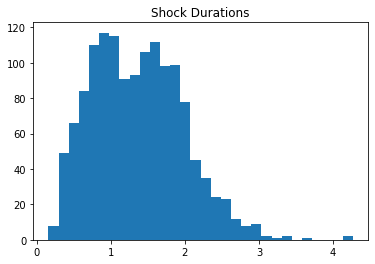

In [9]:
_=plt.hist(shock_durs,bins = 30)
plt.title('Shock Durations')

In [10]:
cov_df = cov_df.merge(BPdiff)
cov_df.set_index('Pair',inplace=True)
cov_df.head()

,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff
Pair,,,,,
P00,27.0,0.0,23.0,-2.0,-87
P01,31.5,9.0,28.0,4.0,-21
P02,36.5,1.0,27.5,3.0,-57
P03,22.5,3.0,20.5,-1.0,-23
P04,33.0,0.0,29.0,6.0,-83


In [11]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cov_df_std = pd.DataFrame(ss.fit_transform(cov_df),columns=cov_df.columns,index=cov_df.index)
cov_df_std.reset_index(inplace=True)

In [12]:
cov_df_std.head()

,Pair,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff
0,P00,-0.988402,-0.055850,-1.213278,-0.144191,-0.837059
1,P01,-0.407588,3.127601,-0.419284,0.496243,0.365774
2,P02,0.237760,0.297867,-0.498684,0.389504,-0.290317
3,P03,-1.569215,1.005300,-1.610275,-0.037452,0.329324
4,P04,-0.213984,-0.055850,-0.260486,0.709720,-0.764160


# Import the ROI-SCR corrlation dataframe to join the covariates on

In [13]:
ROI_SCR_corr_df = pd.read_csv('../data/uncon_v_con_ROI_SCR_zcorr.txt',sep='\t')

In [18]:
ROI_SCR_corr_df.merge(cov_df_std).to_csv('../data/uncon_v_con_ROI_SCR_zcorr.txt',
                                         sep='\t',
                                         float_format='%.5f',
                                         index=False)